# ADS Homework 7

#### Please submit this assignment to NYU Classes 'Assignments' section by labeling the notebook as **'FULL_NAME - ADS_HW7.ipynb'**.
---
This exercise is on Stock price prediction. We will be using Amazon's 10 year stock history to train LSTM network to get predicted stock price for next day, given previous 'n' values which is defined by 'window_size'. There are helper functions which will create the dataset for you, get the predictions from trained network and also plot the predictions. Most important part of this assignment deals with creating the model architecture correctly. You should experiment by adding more layers and playing around with the hyper-parameters in order to improve the accuracy. Extra-credit will be given to novel ideas.

You may reach out to the TAs in case you're having some troubles or getting un-expected errors. Feel free to reach out to Professor Savage as well via email or during office hours.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.dates as mdates
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from  matplotlib.finance import *
%matplotlib inline

from subprocess import check_output
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from sklearn.model_selection import train_test_split
import time #helper libraries
from numpy import newaxis

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The finance module has been deprecated in mpl 2.0 and will be removed in mpl 2.2. Please use the module mpl_finance instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
Using TensorFlow backend.


### Q.1 Read the CSV file, change 'date' column to datetime format and plot the stock price history (10 pts)

In [2]:
### YOUR CODE HERE ###
amazon = pd.read_csv("Amazon_10yr_history.csv")
amazon['date'] = pd.to_datetime(amazon['date'])

In [3]:
amazon.head()

,date,close,volume,open,high,low
0,2018-11-30,1690.17,5744168.0,1679.50,1696.00,1666.500
1,2018-11-29,1673.57,6600424.0,1674.99,1689.99,1652.331
2,2018-11-28,1677.75,8429894.0,1613.92,1681.45,1601.215
3,2018-11-27,1581.42,5758441.0,1575.99,1597.65,1558.010
4,2018-11-26,1581.33,6226531.0,1539.00,1584.81,1524.220


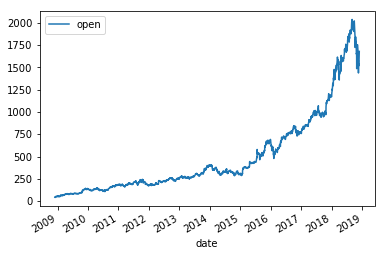

In [4]:
amazon.plot(x="date", y="open")

Figure 1. This is a time series plot that shows the open price for amazon stock value during 10 year period

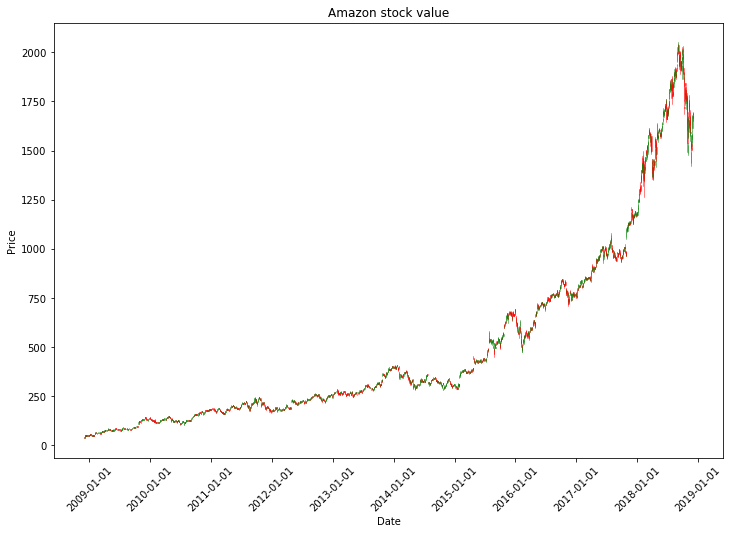

In [5]:
amazon["date2"] = amazon["date"].apply(mdates.date2num)
tuples = [tuple(x) for x in amazon[['date2','open','high','low','close']].values]

fig, ax = plt.subplots(figsize=(12,8))
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
plt.xticks(rotation=45)
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Amazon stock value")
C1 = candlestick_ohlc(ax, tuples, width=.6, colorup='g', alpha =.4)


Figure 2. This is a time series plot that shows the amazon stock value during a 10 year period

In [6]:
amazon.head()

,date,close,volume,open,high,low,date2
0,2018-11-30,1690.17,5744168.0,1679.50,1696.00,1666.500,737028.0
1,2018-11-29,1673.57,6600424.0,1674.99,1689.99,1652.331,737027.0
2,2018-11-28,1677.75,8429894.0,1613.92,1681.45,1601.215,737026.0
3,2018-11-27,1581.42,5758441.0,1575.99,1597.65,1558.010,737025.0
4,2018-11-26,1581.33,6226531.0,1539.00,1584.81,1524.220,737024.0


### Q.2 Scale the data using MinMaxScaler (5 pts)

In [31]:
scaler = MinMaxScaler(feature_range=(0, 1))
amazon_ = amazon[['date','close','volume','open','high','low']]
close = amazon[['close']]
amazon_['close'] = scaler.fit_transform(close)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [32]:
amazon_.head()

,date,close,volume,open,high,low
0,2018-11-30,0.825246,5744168.0,1679.50,1696.00,1666.500
1,2018-11-29,0.816942,6600424.0,1674.99,1689.99,1652.331
2,2018-11-28,0.819033,8429894.0,1613.92,1681.45,1601.215
3,2018-11-27,0.770845,5758441.0,1575.99,1597.65,1558.010
4,2018-11-26,0.770800,6226531.0,1539.00,1584.81,1524.220


In [33]:
amazon_['date'] = pd.to_datetime(amazon_['date'])
amazon_ = amazon_.sort_values(['date']).reset_index()


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [34]:
amzn = amazon_[['date','close','volume','open','high','low']]

In [35]:
amzn.head()

,date,close,volume,open,high,low
0,2008-12-01,0.000000,11178700.0,42.00,43.26,40.38
1,2008-12-02,0.000360,8713657.0,41.39,41.71,38.82
2,2008-12-03,0.002371,15672860.0,40.16,45.88,40.05
3,2008-12-04,0.003427,19781350.0,45.94,50.50,45.75
4,2008-12-05,0.003897,14607480.0,45.89,48.49,43.30


#### Creates dataset in correct format for RNNs

In [12]:
def create_dataset(dataset, window_size):
    """
    Creates x and y data sets used for training the LSTM model in the format which is acceptable by Keras API
    Parameters:
        data : Stock price history (as numpy array)
        window_size : Number of data points to be used to predict/forecast next data point
    
    Returns:
        x : Feature inputs
        y : Target labels
    """
    data_X, data_Y = [], []
    for i in range(len(dataset) - window_size - 1):
        # Creating sets of data points (close price) to predict for next day
        data_X.append(dataset[i:(i + window_size), 1]) ## 1 - 'close' price from dataframe
        data_Y.append(dataset[i + window_size, 1])
    # Converting list to numpy array
    data_X = np.array(data_X)
    data_Y = np.array(data_Y)
    # Reshaping it according to LSTM input
    x = np.reshape(data_X, (data_X.shape[0], 1, data_X.shape[1]))
    y = np.reshape(data_Y, (data_Y.shape[0], 1,1))
    return x, y

window_size = 22
x, y = create_dataset(amzn.values, window_size)

In [13]:
x

array([[[0.0, 0.00036017288298383077, 0.0023711381463102296, ...,
         0.00446714422923003, 0.005147470785977267, 0.005407595645910038]],

       [[0.00036017288298383077, 0.0023711381463102296,
         0.003426644789498959, ..., 0.005147470785977267,
         0.005407595645910038, 0.006948335200896431]],

       [[0.0023711381463102296, 0.003426644789498959,
         0.0038968704978389612, ..., 0.005407595645910038,
         0.006948335200896431, 0.006798263166319835]],

       ..., 
       [[0.8712682087401953, 0.8015547462782134, 0.7495647910997278, ...,
         0.7384844725468224, 0.7311459500560268, 0.7707999839923162]],

       [[0.8015547462782134, 0.7495647910997278, 0.7453327597246678, ...,
         0.7311459500560268, 0.7707999839923162, 0.7708450056026892]],

       [[0.7495647910997278, 0.7453327597246678, 0.779143989114775, ...,
         0.7707999839923162, 0.7708450056026892, 0.8190331359052344]]], dtype=object)

### Q.3 Create the model containing LSTM layers (20 pts)
----
Input shape of first 'LSTM' layer : (1, window_size)<br>
Output  of final 'Dense' layer : 1

In [14]:
train, test = train_test_split(amazon_,test_size=0.2)
print (len(train), len(test))

2015 504


In [30]:
def lstm_model(x, window_size):
    """
    Creates the model which will be used to forecast next day's stock price based on previous values as inputs
    Parameters:
        x : Feature inputs
        window_size : Number of data points to be used to predict/forecast next data point
    
    Returns:
        model : Model architecture created using Keras
    """
    ### YOUR CODE HERE ###
    model = Sequential()
    
    model.add(LSTM(output_dim=50, input_shape=(1, 22), return_sequences=True,input_dim=1))
    model.add(Dropout(0.2))
    
    model.add(Dense(units=1))

    # Compile, fit, and generate scores and predicted probabilities.
    # model.compile(loss='mse', optimizer='adam', metrics=['mse'])

    #model.fit(data, labels, epochs=20, batch_size=100)
    #model.fit(x, y, epochs=20, batch_size=200, verbose=2)
    #pred = model.predict(x)
    print (model.summary())
    return model

model = lstm_model(x, window_size)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/ipykernel_launcher.py:14: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/ipykernel_launcher.py:14: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=True, units=50, input_shape=(None, 1))`
  


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, None, 50)          10400     
_________________________________________________________________
dropout_8 (Dropout)          (None, None, 50)          0         
_________________________________________________________________
dense_8 (Dense)              (None, None, 1)           51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________
None


### Q.4 Compile the model by specifying optimizer, loss metrics and train the network by specifying batch_size and epochs (10 pts)

Play around with the hypar-parameters and **discuss** what changes caused the mean-squared error go up or down

In [16]:
model_1 = lstm_model(x, window_size)
#Compile, fit, and generate scores and predicted probabilities.
model_1.compile(loss='mse', optimizer='adam', metrics=['mse'])
#model.fit(data, labels, epochs, batch_size)
model_1.fit(x, y, epochs=5, batch_size=200, verbose=2)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/ipykernel_launcher.py:14: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=True, units=50, input_shape=(1, 22))`
  


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 1, 50)             14600     
_________________________________________________________________
dropout_2 (Dropout)          (None, 1, 50)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 1, 1)              51        
Total params: 14,651
Trainable params: 14,651
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
 - 2s - loss: 0.0842 - mean_squared_error: 0.0842
Epoch 2/5
 - 0s - loss: 0.0090 - mean_squared_error: 0.0090
Epoch 3/5
 - 0s - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 4/5
 - 0s - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 5/5
 - 0s - loss: 0.0028 - mean_squared_error: 0.0028


In [17]:
model_2 = lstm_model(x, window_size)
#Compile, fit, and generate scores and predicted probabilities.
model_2.compile(loss='mse', optimizer='adam', metrics=['mse'])

#model.fit(data, labels, epochs, batch_size)
model_2.fit(x, y, epochs=20, batch_size=200, verbose=2)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/ipykernel_launcher.py:14: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=True, units=50, input_shape=(1, 22))`
  


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 1, 50)             14600     
_________________________________________________________________
dropout_3 (Dropout)          (None, 1, 50)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 1, 1)              51        
Total params: 14,651
Trainable params: 14,651
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
 - 2s - loss: 0.0464 - mean_squared_error: 0.0464
Epoch 2/20
 - 0s - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 3/20
 - 0s - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 4/20
 - 0s - loss: 0.0021 - mean_squared_error: 0.0021
Epoch 5/20
 - 0s - loss: 0.0020 - mean_squared_error: 0.0020
Epoch 6/20
 - 0s - loss: 0.0016 - mean_squared_error: 0.0016
Epoch 7/20
 - 0s - loss: 0.0015

In [18]:
model_3 = lstm_model(x, window_size)
#Compile, fit, and generate scores and predicted probabilities.
model_3.compile(loss='mse', optimizer='adam', metrics=['mse'])

#model.fit(data, labels, epochs=20, batch_size=100)
model_3.fit(x, y, epochs=22, batch_size=200, verbose=2)



/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/ipykernel_launcher.py:14: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=True, units=50, input_shape=(1, 22))`
  


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 1, 50)             14600     
_________________________________________________________________
dropout_4 (Dropout)          (None, 1, 50)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 1, 1)              51        
Total params: 14,651
Trainable params: 14,651
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/22
 - 2s - loss: 0.0667 - mean_squared_error: 0.0667
Epoch 2/22
 - 0s - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 3/22
 - 0s - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 4/22
 - 0s - loss: 0.0022 - mean_squared_error: 0.0022
Epoch 5/22
 - 0s - loss: 0.0023 - mean_squared_error: 0.0023
Epoch 6/22
 - 0s - loss: 0.0018 - mean_squared_error: 0.0018
Epoch 7/22
 - 0s - loss: 0.0017

In [19]:
model_4 = lstm_model(x, window_size)
#Compile, fit, and generate scores and predicted probabilities.
model_4.compile(loss='mse', optimizer='adam', metrics=['mse'])

#model.fit(data, labels, epochs=20, batch_size=100)
model_4.fit(x, y, epochs=20, batch_size=100, verbose=2)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/ipykernel_launcher.py:14: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=True, units=50, input_shape=(1, 22))`
  


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 1, 50)             14600     
_________________________________________________________________
dropout_5 (Dropout)          (None, 1, 50)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 1, 1)              51        
Total params: 14,651
Trainable params: 14,651
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
 - 2s - loss: 0.0606 - mean_squared_error: 0.0606
Epoch 2/20
 - 0s - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 3/20
 - 0s - loss: 0.0020 - mean_squared_error: 0.0020
Epoch 4/20
 - 0s - loss: 0.0017 - mean_squared_error: 0.0017
Epoch 5/20
 - 0s - loss: 0.0014 - mean_squared_error: 0.0014
Epoch 6/20
 - 0s - loss: 0.0015 - mean_squared_error: 0.0015
Epoch 7/20
 - 0s - loss: 0.0012

In [20]:
model_5 = lstm_model(x, window_size)
#Compile, fit, and generate scores and predicted probabilities.
model_5.compile(loss='mse', optimizer='adam', metrics=['mse'])

#model.fit(data, labels, epochs=20, batch_size=100)
model_5.fit(x, y, epochs=20, batch_size=600, verbose=2)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/ipykernel_launcher.py:14: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=True, units=50, input_shape=(1, 22))`
  


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 1, 50)             14600     
_________________________________________________________________
dropout_6 (Dropout)          (None, 1, 50)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 1, 1)              51        
Total params: 14,651
Trainable params: 14,651
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
 - 2s - loss: 0.0498 - mean_squared_error: 0.0498
Epoch 2/20
 - 0s - loss: 0.0182 - mean_squared_error: 0.0182
Epoch 3/20
 - 0s - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 4/20
 - 0s - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 5/20
 - 0s - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 6/20
 - 0s - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 7/20
 - 0s - loss: 0.0021

In [21]:
model_6 = lstm_model(x, window_size)
#Compile, fit, and generate scores and predicted probabilities.
model_6.compile(loss='mse', optimizer='adam', metrics=['mse'])

#model.fit(data, labels, epochs=20, batch_size=100)
model_6.fit(x, y, epochs=20, batch_size=40, verbose=2)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/ipykernel_launcher.py:14: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=True, units=50, input_shape=(1, 22))`
  


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 1, 50)             14600     
_________________________________________________________________
dropout_7 (Dropout)          (None, 1, 50)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 1, 1)              51        
Total params: 14,651
Trainable params: 14,651
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
 - 2s - loss: 0.0150 - mean_squared_error: 0.0150
Epoch 2/20
 - 0s - loss: 0.0016 - mean_squared_error: 0.0016
Epoch 3/20
 - 0s - loss: 0.0014 - mean_squared_error: 0.0014
Epoch 4/20
 - 0s - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 5/20
 - 0s - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 6/20
 - 0s - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 7/20
 - 0s - loss: 0.0010

**A epoch is an iteration over the entrie x and y providee. Batch size it the number of samples per gradient updated. When I increase the epochs, MSE increases, but when it reaches 20, the mse start to decrease fast. When I keeps the epochs the same and increase the batch size, the mse decrease at first and then, when the batch_size is high enough (such as 600), mse increases and stable at some point. When I use lower batch_size, the mse descrease.**  However, when both the parameters are high, the model might be overfitting.

### Q.5 Get the predictions and visualize the results (5 pts)
Helper functions will do the needful, you just need to make sure the model is trained and data is consistent

In [22]:
amzn.head()

,date,close,volume,open,high,low
0,2008-12-01,0.000000,11178700.0,42.00,43.26,40.38
1,2008-12-02,0.000360,8713657.0,41.39,41.71,38.82
2,2008-12-03,0.002371,15672860.0,40.16,45.88,40.05
3,2008-12-04,0.003427,19781350.0,45.94,50.50,45.75
4,2008-12-05,0.003897,14607480.0,45.89,48.49,43.30


In [23]:
x.shape

(2496, 1, 22)

In [24]:
def predict(amzn, x, window_size, batch_size=8):
    """
    Uses trained model to predict on the input set, scales data back to original distribution
    and returns the original dataframe with an added column containing predictions
    
    Parameters:
        amzn : Original dataframe of Amazon stock prices
        x : Feature inputs used to train the model
        batch_size : Batch_size used for training the model
    
    Returns:
        amzn : Amazon stock price dataframe with an added column containing predictions made by the trained model
    """
    preds = []
    amzn.reset_index(drop=True, inplace=True)
    # Iterating over training samples
    for i in range(len(x)):
        data = np.reshape(x[i], (1, 1, 22))
        # Predicting from the trained model
        preds.append(model_4.predict(x=data,batch_size=22)[0][0][0])

    predictions = np.copy(scaler.inverse_transform(np.array(preds).reshape(-1, 1)))
    amzn.loc[window_size+1:,'Predictions'] = np.copy(predictions)
    amzn.loc[:,'close'] = np.copy(scaler.inverse_transform(amzn.loc[:,'close'].values.reshape(-1, 1)))
    return amzn

am = predict(amzn, x, window_size)

In [25]:
amzn.head()

,date,close,volume,open,high,low,Predictions
0,2008-12-01,40.47,11178700.0,42.00,43.26,40.38,NaN
1,2008-12-02,41.19,8713657.0,41.39,41.71,38.82,NaN
2,2008-12-03,45.21,15672860.0,40.16,45.88,40.05,NaN
3,2008-12-04,47.32,19781350.0,45.94,50.50,45.75,NaN
4,2008-12-05,48.26,14607480.0,45.89,48.49,43.30,NaN


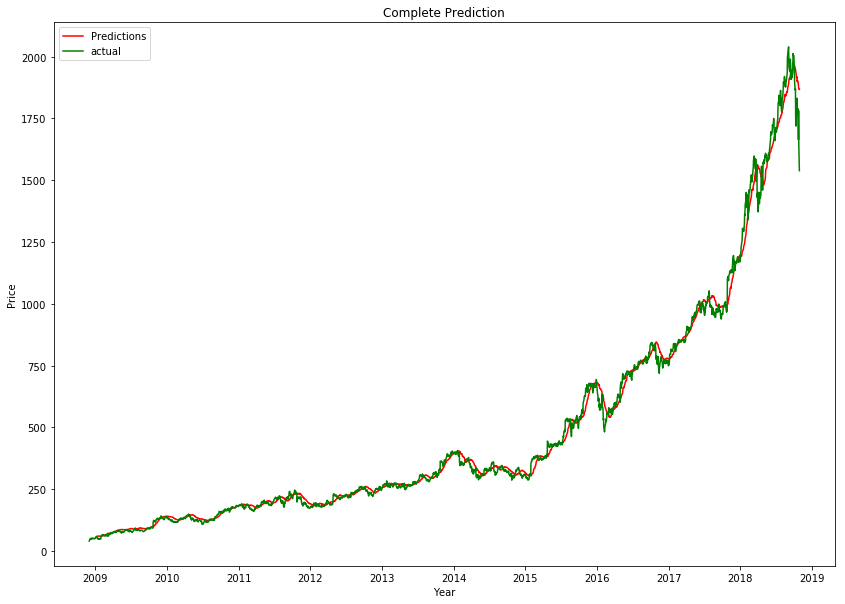

In [26]:
def plot_predictions(amzn, title, idx1=0, idx2=len(x)):
    """
    Plots the predictions on top of original stock price history
    
    Parameters:
        amzn : Original dataframe of Amazon stock prices
        title : Title of the plot
    
    Returns:
        amzn : Amazon stock price dataframe with an added column containing predictions made by the trained model
    """
    plt.figure(figsize=(14, 10))
    plt.plot(amzn.date[idx1:idx2], amzn.Predictions[idx1:idx2], label='Predictions', color='red')
    plt.plot(amzn.date[idx1:idx2], amzn.close[idx1:idx2], label='actual', color='green')
    plt.xlabel("Year")
    plt.ylabel("Price")
    plt.title(title)
    plt.legend()
    plt.show()
    
# The plot should look something like this    
title = "Complete Prediction"
plot_predictions(amzn, title)

Figure 3. The predict and actual price of amazon stock over 10 year period

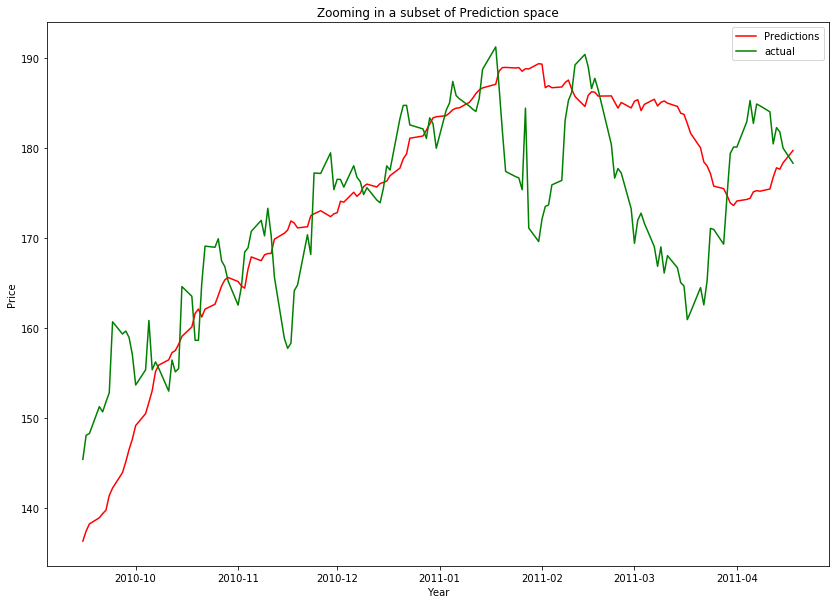

In [27]:
# Same function can be used to zoom in on a particular sub-space of predictions
title = "Zooming in a subset of Prediction space"
plot_predictions(amzn, title, 450, 600)

Figure 4. The zoom in to a subset of amazon stock prediction.